# Project 2 - Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)




### Read Data

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark')

In [2]:
# read in SOTU.csv using pandas, name the variable `sou` for simplicity
# the below cell is what the output should look like

from src import part00_utils_visuals as part00
# import src.part00_utils_visuals as part00

part00.plot_style(style=part00.PLOT_STYLE_SEABORN)

sou = part00.pd.read_csv(part00.DIR_DATA_RAW / part00.CSV_SOTU)

In [3]:
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069



Now we will start working on simple text processing using the `SpaCy` package and the same dataset as Part 1. The package should already be included in the `environment.yml`. However, we will also need to download `en_core_web_sm`, an English language text processing model. To do this, while having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

Now, you should be good to go!

Some important definitions:

- *Token*: a single word or piece of a word
- *Lemma*: the core component of a word, e.g., "complete" is the lemma for "completed" and "completely"
- *Stop Word*: a common word that does not add semantic value, such as "a", "and", "the", etc.
- *Vectorization*: representing a document as a vector where each index in the vector corresponds to a token or word and each entry is the count.

In this section, we will explore the most common tokens and lemmas throughout different slices of the speech data. We will also develop vectorization representations of the speeches. 

 The core steps are:

1. Process speeches using the SpaCy nlp module
2. Analyze Tokens vs Lemmas:
- Create a list of all tokens across all speeches that are not stop words, punctuation, or spaces.
- Create a second list of the lemmas for these same tokens.
- Display the top 25 for each of these and compare.
3. Analyze common word distributions over different years:
- Create a function that takes the dataset and a year as an input and outputs the top n lemmas for that year's speeches
- Compare the top 10 words for 2023 versus 2019
4. Document Vectorization:
- Train a Term Frequency-Inverse Document Frequency (TF-IDF) vectorization model using your processed dataset and scikit learn
- Output the feature vectors 

**Helpful Resources:**
- https://realpython.com/natural-language-processing-spacy-python/
- https://www.statology.org/text-preprocessing-feature-engineering-spacy/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html# 
- https://www.geeksforgeeks.org/nlp/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/ 



In [4]:
# TODO: REMOVE - DOES NOT WORK!

# !python -m spacy download en_core_web_sm

In [5]:
# TODO: REMOVE - DOES NOT WORK!

# from IPython import get_ipython

# # Run the command
# ipython = get_ipython()
# ipython.system('python -m spacy download en_core_web_sm')

In [6]:
# TODO: MIGRATE to part01.py - WORKS!

# import spacy 

# spacy.cli.download("en_core_web_sm")

In [7]:
# TODO: MIGRATE to part01.py - WORKS!

# import sys
# # Use the same Python that's running the notebook
# !{sys.executable} -m spacy download en_core_web_sm

### Processing Speeches with SpaCy

Lets study just speeches from 2000 and onwards to begin with. So, be sure to subset your DataFrame to just these speeches before continuing!

In [8]:
import spacy
from tqdm import tqdm
from collections import Counter

In [9]:
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.6 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
nlp.lang

'en'

In [12]:
import pandas as pd
from typing import Union, Optional
import pathlib as pl

def save_the_processed_data_to_csv(
    data: Union[pd.DataFrame, pd.Series],
    filepath: Union[str, pl.Path],
) -> None:

    # Convert Series to DataFrame
    if isinstance(data, pd.Series):
        data_to_save: pd.DataFrame = data.to_frame()
    else:
        data_to_save: pd.DataFrame = data

    data_to_save.to_csv(filepath, index=False)

In [13]:
# subset the speech dataframe for speeches from 2000 and onwards
# Filter for a range of years
sou_step00_year_2000_and_above = sou[sou['Year'] >= 2000]
save_the_processed_data_to_csv(data=sou_step00_year_2000_and_above, filepath=part00.DIR_DATA_PROCESSED / "sou_step00_year_2000_and_above.csv")
sou_step00_year_2000_and_above

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
5,Donald J. Trump,2019.0,"\nThe President. Madam Speaker, Mr. Vice Presi...",5519
6,Donald J. Trump,2018.0,"\nThe President. Mr. Speaker, Mr. Vice Preside...",5755
7,Donald J. Trump,2017.0,"\nThank you very much. Mr. Speaker, Mr. Vice P...",4903
8,Barack Obama,2016.0,"\nThank you. Mr. Speaker, Mr. Vice President, ...",5956
9,Barack Obama,2015.0,"\nThe President. Mr. Speaker, Mr. Vice Preside...",6659


In [14]:
# Process each speeches using the 'nlp' function
# Hint - loop through each speech and pass the text into the nlp function above, storing the output in a list
# should take about 30 seconds to process

sou_step01_year_2000_and_above_text = sou_step00_year_2000_and_above["Text"]
save_the_processed_data_to_csv(data=sou_step01_year_2000_and_above_text, filepath=part00.DIR_DATA_PROCESSED / "sou_step01_year_2000_and_above_text.csv")
sou_step01_year_2000_and_above_text

0     \n[Before speaking, the President presented hi...
1     \nThe President. Mr. Speaker——\n[At this point...
2     \nThe President. Thank you all very, very much...
3     \nThe President. Thank you. Thank you. Thank y...
4     \nThe President. Thank you very much. Thank yo...
5     \nThe President. Madam Speaker, Mr. Vice Presi...
6     \nThe President. Mr. Speaker, Mr. Vice Preside...
7     \nThank you very much. Mr. Speaker, Mr. Vice P...
8     \nThank you. Mr. Speaker, Mr. Vice President, ...
9     \nThe President. Mr. Speaker, Mr. Vice Preside...
10    \nThe President. Mr. Speaker, Mr. Vice Preside...
11    \nPlease, everybody, have a seat. Mr. Speaker,...
12    \nMr. Speaker, Mr. Vice President, Members of ...
13    \nMr. Speaker, Mr. Vice President, Members of ...
14    \nMadam Speaker, Vice President Biden, Members...
15    \nMadam Speaker, Mr. Vice President, Members o...
16    \nThank you all. Madam Speaker, Vice President...
17    \nThank you very much. And tonight I have 

In [15]:
sou_step02_year_2000_above_text_nlp = [nlp(speech) for speech in tqdm(sou_step01_year_2000_and_above_text)]
# save_the_processed_data_to_csv(data=sou_step02_year_2000_above_text_nlp, filepath=part00.DIR_DATA_PROCESSED / "sou_step02_year_2000_above_text_nlp.csv")
sou_step02_year_2000_above_text_nlp;

100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


In [16]:
type(sou_step02_year_2000_above_text_nlp[0])

spacy.tokens.doc.Doc

In [17]:
# type(sou_step02_year_2000_above_text_nlp[0]) --> spacy.tokens.doc.Doc
# type(sou_step02_year_2000_above_text_nlp) --> list

# TODO: save tokens using `from spacy.tokens import DocBin`

### Analyze Tokens vs Lemmas

#### Token List

Create a list of tokens across all speeches that are not spaces, stopwords, or punctuation. Make each token lowercase as well. *Hint: each element of the list we just created are themselves lists of tokens. Token objects have attributes `is_stop`, `is_punct`, and `is_space`.*

In [18]:
# sou_step03_year_2000_above_tokens = [doc for doc in sou_step02_year_2000_above_text_nlp]
# sou_step03_year_2000_above_tokens = [token for doc in sou_step02_year_2000_above_text_nlp for token in doc]
# sou_step03_year_2000_above_tokens = [token.text.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc]
# sou_step03_year_2000_above_tokens = [token.text_.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc 
#                                      if not token.is_stop]
# sou_step03_year_2000_above_tokens = [token.text.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc 
#                                      if not token.is_stop and not token.is_punct]
# sou_step03_year_2000_above_tokens = [token.text.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc 
#                                      if not token.is_stop and not token.is_punct and not token.is_space]
sou_step03_year_2000_above_tokens = [token.text.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc \
                                     if not token.is_stop and not token.is_punct and not token.is_space]
# TODO: save to data/01_processed
sou_step03_year_2000_above_tokens;

In [19]:
# print top 20 tokens
# Hint - use Counter, and one of the Counter object's methods to display the top 20

sou_step04_year_2000_above_tokens_count = Counter(sou_step03_year_2000_above_tokens)
sou_step04_year_2000_above_tokens_count

# TODO: save to data/01_processed
sou_step05_year_2000_above_tokens_top20 = sou_step04_year_2000_above_tokens_count.most_common(20)


In [20]:
type(sou_step04_year_2000_above_tokens_count), type(sou_step05_year_2000_above_tokens_top20)

(collections.Counter, list)

In [21]:
sou_step05_year_2000_above_tokens_top20 = pd.DataFrame(sou_step05_year_2000_above_tokens_top20, columns=["Word", "Count"])

In [22]:
type(sou_step04_year_2000_above_tokens_count), type(sou_step05_year_2000_above_tokens_top20)

(collections.Counter, pandas.core.frame.DataFrame)

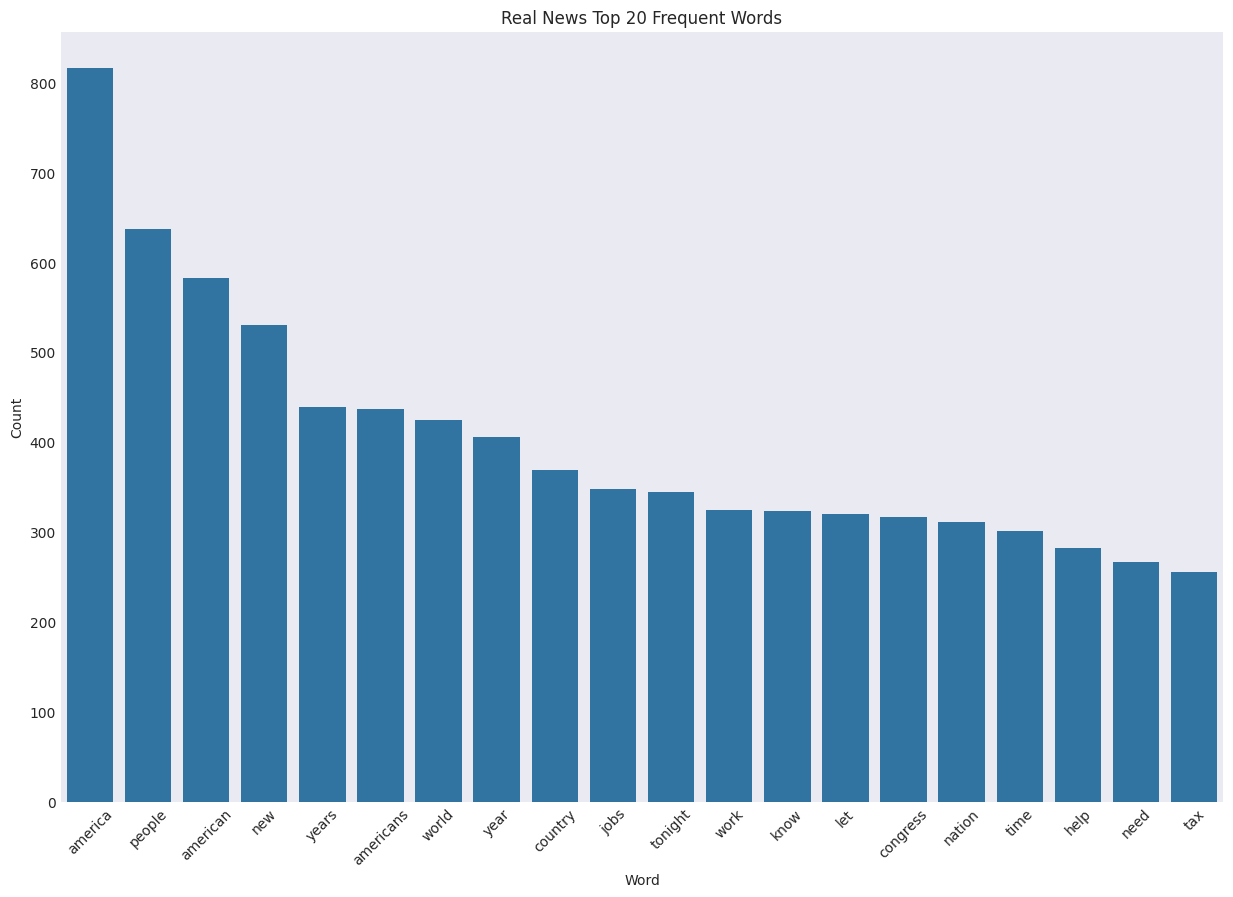

In [23]:
import seaborn as sns

def plot_top(
    token_counts: Counter,
    n: int = 20,
) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    # part00.sns.barplot(token_counts, x="Word", y="Count", ax=ax)
    sns.barplot(token_counts, x="Word", y="Count", ax=ax)
    ax.set_title(f"Real News Top {n} Frequent Words")
    ax.tick_params(axis='x', labelrotation=45)

plot_top(token_counts=sou_step05_year_2000_above_tokens_top20)

#### Lemma List

Do the same as above, but for lemmas. *Hint: recall lemmas are components of words. Each token should have an attribute to extract the lemma.*

In [24]:
# sou_step06_year_2000_above_lemmas = [doc for doc in sou_step02_year_2000_above_text_nlp]
# sou_step06_year_2000_above_lemmas = [token for doc in sou_step02_year_2000_above_text_nlp for token in doc]
# sou_step06_year_2000_above_lemmas = [token.lemma_.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc]
# sou_step06_year_2000_above_lemmas = [token.lemma_.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc 
#                                      if not token.is_stop]
# sou_step06_year_2000_above_lemmas = [token.lemma_.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc 
#                                      if not token.is_stop and not token.is_punct]
# sou_step06_year_2000_above_lemmas = [token.lemma_.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc 
#                                      if not token.is_stop and not token.is_punct and not token.is_space]
sou_step06_year_2000_above_lemmas = [token.lemma_.lower() for doc in sou_step02_year_2000_above_text_nlp for token in doc \
                                     if not token.is_stop and not token.is_punct and not token.is_space]
# TODO: save to data/01_processed
sou_step06_year_2000_above_lemmas;

In [25]:
sou_step07_year_2000_above_lemmas_count = Counter(sou_step06_year_2000_above_lemmas)
sou_step07_year_2000_above_lemmas_count

# TODO: save to data/01_processed
sou_step08_year_2000_above_lemmas_top20 = sou_step07_year_2000_above_lemmas_count.most_common(20)
sou_step08_year_2000_above_lemmas_top20 = pd.DataFrame(sou_step08_year_2000_above_lemmas_top20, columns=["Word", "Count"])

### Token versus Lemma Plot

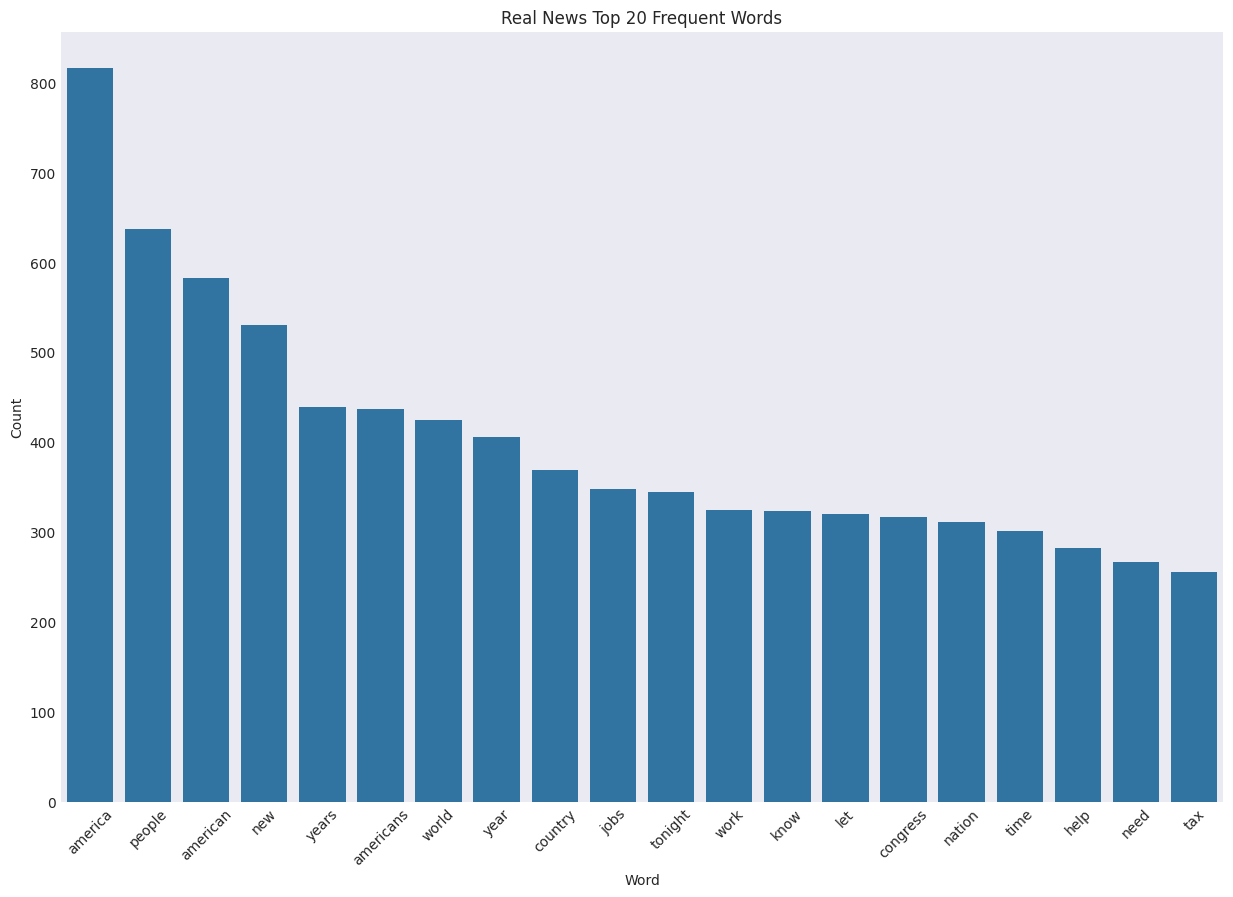

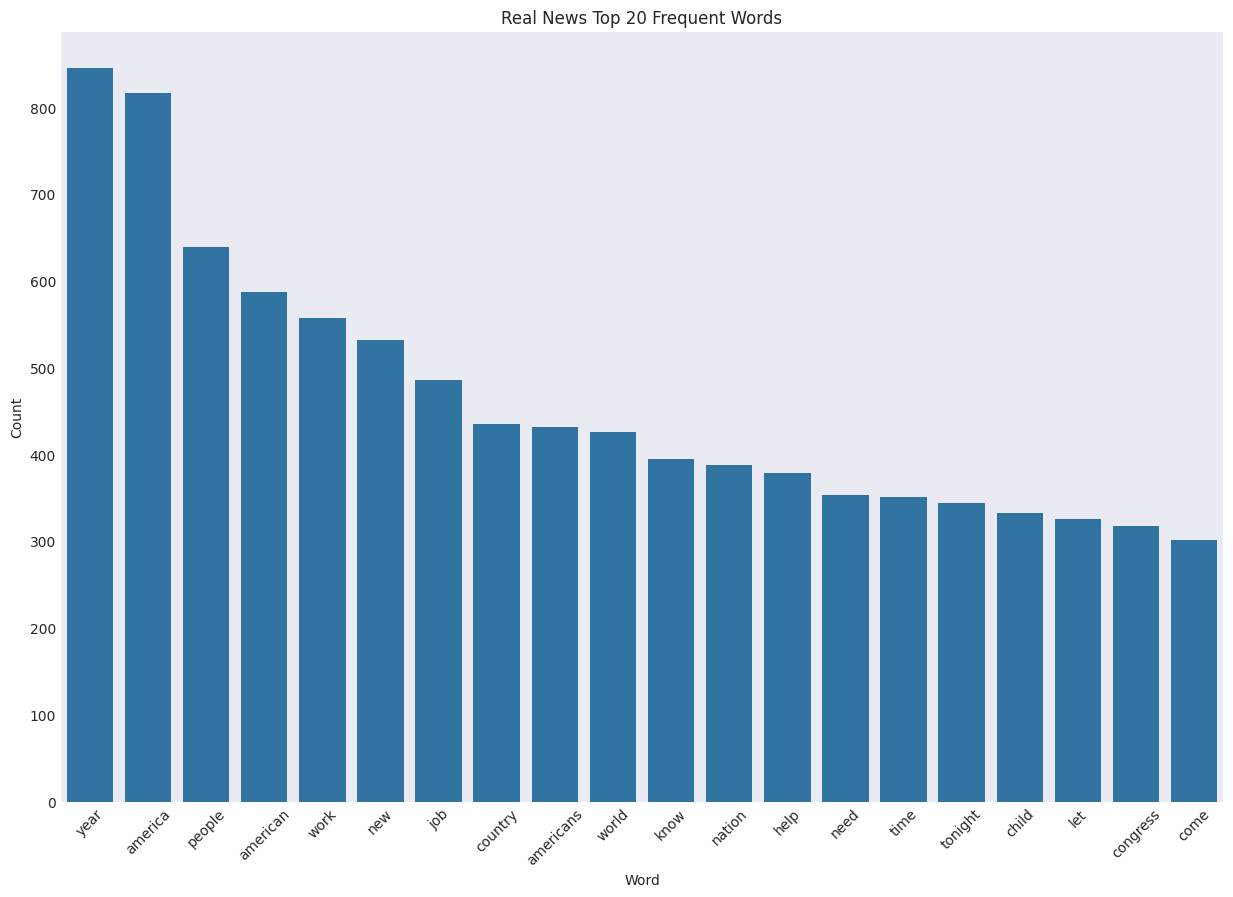

In [26]:
plot_top(token_counts=sou_step05_year_2000_above_tokens_top20)

plot_top(token_counts=sou_step08_year_2000_above_lemmas_top20)

#### Token versus Lemma Comparison

What do you notice about the top tokens versus the top lemmas? 
Consider two tokens - "year" and "years" - how do their counts compare to the lemma "year"?
What about the lemma "child"?

In [27]:
# TODO - Answer here?

### Common Words

#### Common Words per Year Function

Fill in the below function to obtain the n-most common words in speeches for a given year.

inputs: 
- df raw unprocessed sou dataframe
- year
- n
outputs: 
- top n words for that years

steps:
- subset the dataframe for the year of interest - note the years might not be in int type
- process the subsetted dataframe with spacy
- get the lemmas across all those speeches
- count the top n lemmas

In [28]:
def get_most_common_words(
    df: pd.DataFrame, 
    year: int, 
    n:int = 25
) -> Counter:
# ) -> pd.DataFrame:
    
    """
    Processes the SOTU speech for a given year and returns
    the most common non-stopword/punctuation lemmas.
    """

    # Step 1: Subset df
    df_subset = df[df["Year"] == year]
    
    # Step 2: Process the text with spaCy
    # spacy.cli.download("en_core_web_sm")
    # nlp = spacy.load("en_core_web_sm")
    # nlp.lang
    df_subset_text = df_subset["Text"]
    df_subset_nlp = [nlp(speech) for speech in tqdm(df_subset_text)]
    # tokens = [token.text.lower() for doc in df_subset_nlp for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    lemmas = [token.lemma_.lower() for doc in df_subset_nlp for token in doc if not token.is_stop and not token.is_punct and not token.is_space] 
    
    # Step 3: Get lemmas
    lemma_counts = Counter(lemmas).most_common(n)
    # df_lemma_counts = pd.DataFrame(lemma_counts, columns=["Word", "Count"])
    
    
    return lemma_counts

In [29]:
# test it on 2024

top25_in_2024 = get_most_common_words(df=sou, year=2024, n=25)
top25_in_2024

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29),
 ('pay', 29),
 ('come', 26),
 ('home', 25),
 ('family', 24),
 ('future', 23),
 ('million', 23),
 ('like', 21),
 ('build', 21),
 ('laughter', 20),
 ('americans', 20),
 ('history', 19),
 ('world', 19),
 ('right', 19),
 ('tax', 19),
 ('house', 18)]

In [30]:
type(top25_in_2024)

list

In [31]:
df_top25_in_2024 = pd.DataFrame(top25_in_2024, columns=["Word", "Count"])

In [32]:
type(df_top25_in_2024)

pandas.core.frame.DataFrame

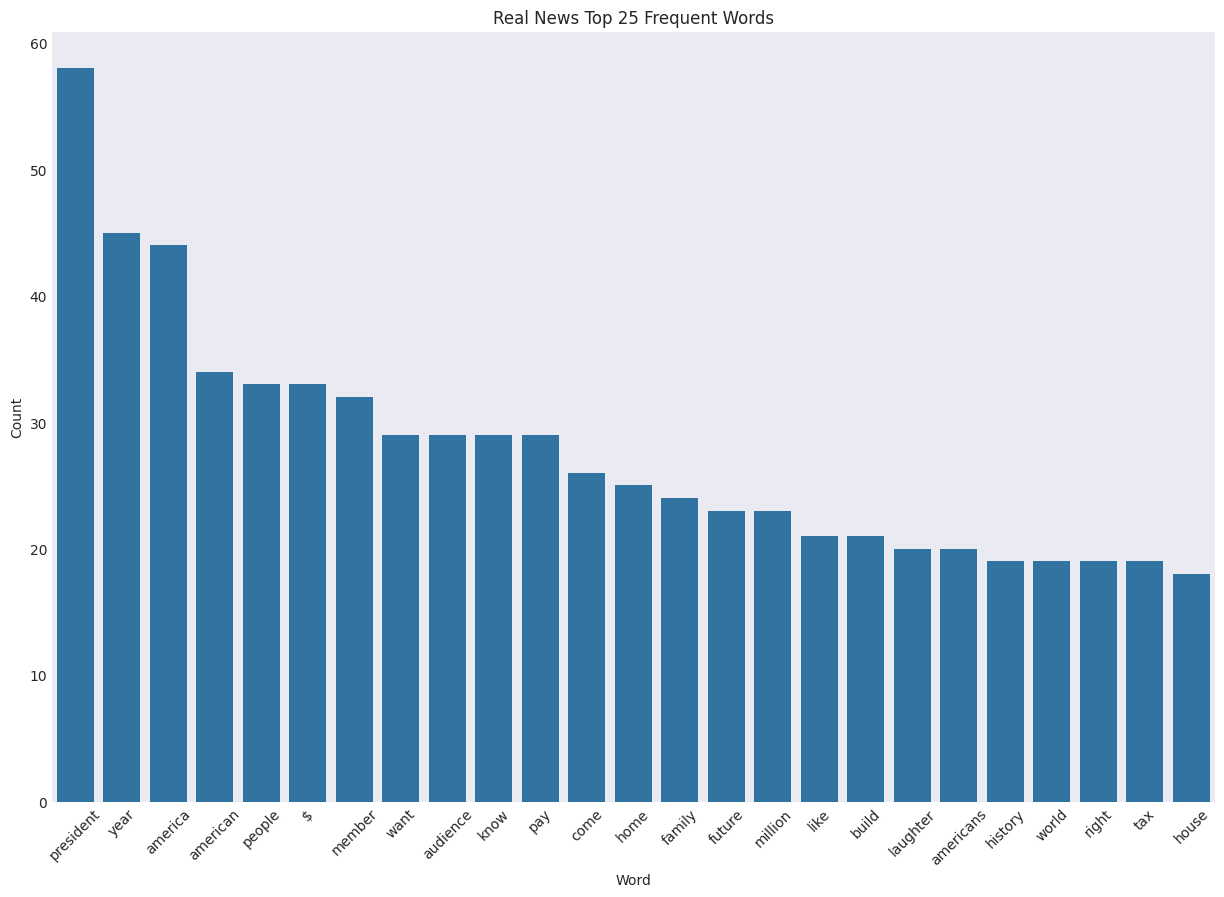

In [33]:
plot_top(df_top25_in_2024, n=25)

#### Compare 2023 to 2017

Run your function from the previous step to get the top 20 words for 2017 and 2023. Plot the words and their frequencies in a barchart and replicate the figure below.

In [34]:
words_2023 =  get_most_common_words(df=sou, year=2023, n=25)

words_2017 =  get_most_common_words(df=sou, year=2017, n=25)


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


In [35]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23),
 ('member', 22),
 ('need', 22),
 ('home', 21),
 ('million', 21),
 ('new', 20)]

In [36]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11),
 ('long', 10),
 ('create', 10),
 ('ask', 10),
 ('thank', 9),
 ('friend', 9)]

In [37]:
# Hint - put the words and counts into a pd Dataframe for better structure
# and to make plotting easier
df_2017 = pd.DataFrame(words_2017, columns=["Word", "Count"])
df_2023 = pd.DataFrame(words_2023, columns=["Word", "Count"])

In [38]:
df_2017

,Word,Count
0,american,34
1,america,29
2,country,26
3,nation,21
4,great,20
5,new,19
6,year,19
7,world,18
8,job,15
9,people,15


In [39]:
df_2023

,Word,Count
0,year,58
1,go,56
2,let,45
3,know,40
4,people,39
5,job,38
6,america,36
7,come,33
8,law,33
9,pay,33


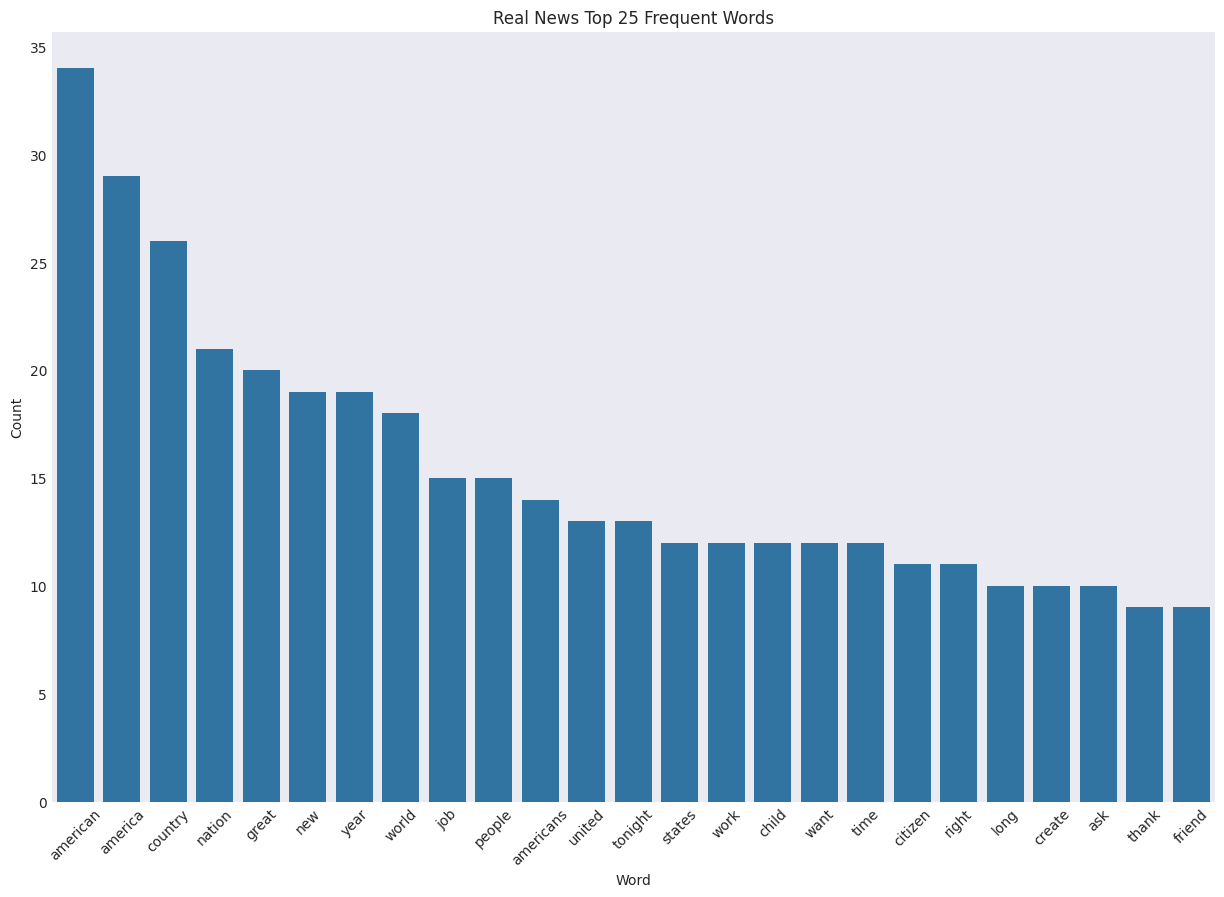

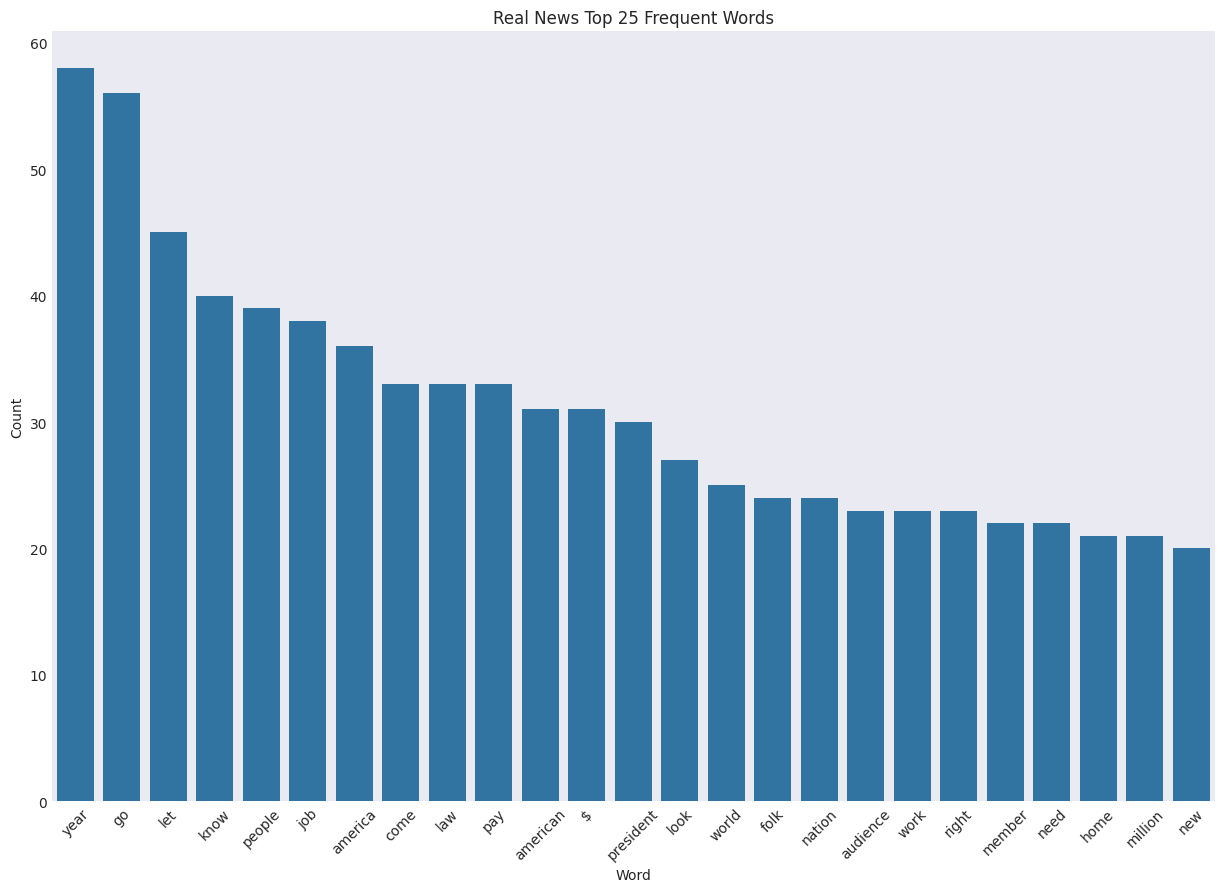

In [40]:
# Hint - use seaborn, subplots, and rotate tick labels

plot_top(df_2017, n=25)

plot_top(df_2023, n=25)

### TF-IDF Vectorization

To use statsitical alorithms on documents, we need to transform them into vectors, where each element of the vector corresponds to a particular word in a document or corpus of documents. One common way is via TF-IDF embeddings. LLMs work similarly - they typically use transformer models to generate text embeddings before sending text through a deep neural network. 

Here we will fit a TF-IDF vectorizer, plot all the speeches on a 2-D grid using PCA and also using a heatmap, and examine TF-IDF scores for the top 10 most common words in the first speech. This is a good resource here: https://medium.com/GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d 

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [42]:
# you may use this as input to fit the TF-IDF vectorizer
raw_docs = sou["Text"].to_list()
step09_df_raw_docs = pd.DataFrame(raw_docs)
save_the_processed_data_to_csv(data=step09_df_raw_docs, filepath=part00.DIR_DATA_VECTORIZED / "step09_raw_docs.csv")

The output of `fit_transform()` will be a matrix where each row corresponds to a speech, each column corresponds to a word in the corpus of speeches, and the value is the TF-IDF score which measures the importance of that word in that speech, relative to the rest of the speeches.

In [43]:
# Hint - use fit_transform for vectorizer and PCA
# Reference:
# - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# modeltype: Embedding Model aka Featurization Model aka Vectorization Model
vectorizer = TfidfVectorizer()
step10_vectorized_raw_docs_tfidf = vectorizer.fit_transform(raw_docs)

# matrixtype: Compressed Sparse Row Matrix
step10_vectorized_raw_docs_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 426898 stored elements and shape (246, 25957)>

In [44]:
step10_vectorized_raw_docs_tfidf.shape

(246, 25957)

In [45]:
step10_feature_names = vectorizer.get_feature_names_out()
type(step10_feature_names)

numpy.ndarray

In [51]:
import numpy as np

def save_the_vectorized_data_to_csv(
    data_tfidf_matrix: Union[pd.DataFrame, pd.Series],
    data_tfidf_feature_names: np.ndarray,
    filepath: Union[str, pl.Path],
) -> None:
    """
        Convert TF-IDF to dense matrix and save as CSV (inefficient!)

        NOTE: Only use this for small datasets.
    """

    # Convert the CSR matrix to a Dense Matrix
    dense_matrix = data_tfidf_matrix.toarray()

    # 
    df = pd.DataFrame(dense_matrix, columns=data_tfidf_feature_names)
    df.to_csv(f"{filepath}", index=False)

    return df


save_the_vectorized_data_to_csv(data_tfidf_matrix=step10_vectorized_raw_docs_tfidf, data_tfidf_feature_names=step10_feature_names, filepath = part00.DIR_DATA_VECTORIZED / "step10_vectorized_raw_docs_tfidf.csv")

,00,000,0000,0001,000m,000page,001,002,003,004,...,zimbabwean,zinc,zion,zollverein,zone,zones,zoological,zooming,zuloaga,ôtil
0,0.0,0.021959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.027715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.016401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.015540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.008169,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.034205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.017812,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0.0,0.018668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
242,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
243,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
244,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


#### Plot Speeches

- First used PCA to generate the first chart
- Second use seaborn heatmap with a log-scaled color axis to generate the second chart

In [52]:
# Hint - vectorized_docs is a sparse matrix whose rows are speeches and columns are tokens, with each
# value being a TF-IDF score. Densify this array first, and then plot using seaborn.

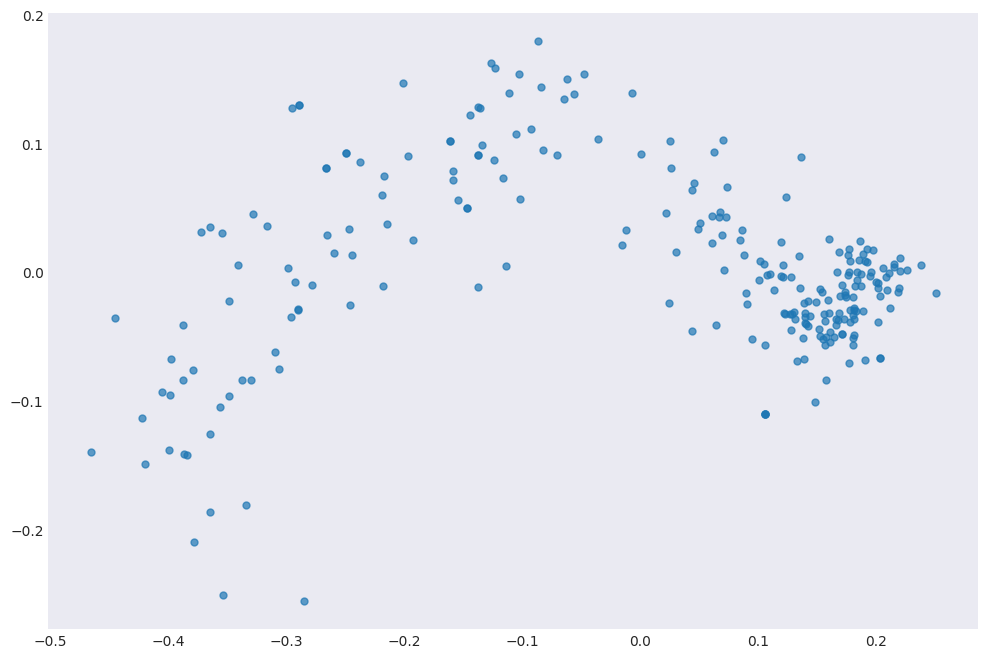

In [53]:
# https://scikit-learn.org/0.17/modules/generated/sklearn.decomposition.PCA.html

# Step 1: Set PCA to find first 2 principal components
step11_pca = PCA(n_components=2)

# Step 2: Create a new dataframe where each row is a speech, and each column is a projection onto
# one of the two principal components
step11_pca_result = step11_pca.fit_transform(step10_vectorized_raw_docs_tfidf)
step11_pca_result;

step11_pca_result_df = pd.DataFrame(
    data=step11_pca_result,
    columns=['PC1', 'PC2']
)
step11_pca_result_df
save_the_vectorized_data_to_csv(


# Plot Data Visualization (Matplotlib)
plt.figure(figsize=(12, 8))
plt.scatter(step11_pca_result_df['PC1'], step11_pca_result_df['PC2'], alpha=0.7, s=25);

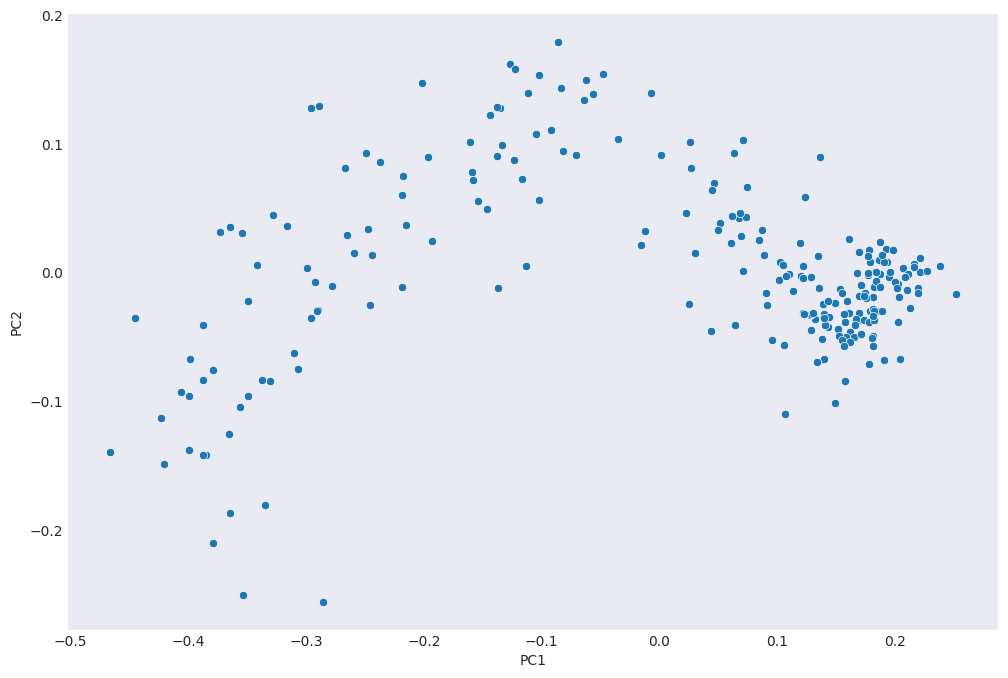

In [54]:
plt.figure(figsize=(12, 8))
sns.scatterplot(step11_pca_result_df, x="PC1", y="PC2");

#### Get the TF-IDF value for certain words and documents

In [55]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [56]:
# print("Learned vocabulary:", vectorizer.vocabulary_)
vocab_dict = vectorizer.vocabulary_
type(vocab_dict)
vocab_dict.get(word_list[0])

25879

In [57]:
word_nums = [vocab_dict.get(word) for word in word_list] # get each word's index number using the .vocabular_ attributed of vectorizer
word_nums

[25879, 2410, 17259, 2412, 25728, 15972, 13576, 6506, 2416, 25753]

In [64]:
idf_scores = vectorizer.idf_
idf_scores

idf_score = [idf_scores[num] for num in word_nums]  # get their IDF score by using .idf_ at the indices from the previous step
idf_score

[np.float64(1.0329247846964666),
 np.float64(1.272946373798028),
 np.float64(1.0371176629565027),
 np.float64(1.1022165651678586),
 np.float64(1.1622808059105085),
 np.float64(1.0245914031373222),
 np.float64(2.0434802179733937),
 np.float64(1.0081301260832503),
 np.float64(1.713597791031236),
 np.float64(1.1387503085003143)]

In [62]:
type(step10_vectorized_raw_docs_tfidf[0])
first_speech_vector_tfidf = step10_vectorized_raw_docs_tfidf[0]
first_speech_vector_tfidf

# tf_idf = ... # get the tf_idf score for the first speech
tf_idf = [first_speech_vector_tfidf[0, idx] for idx in word_nums]
tf_idf

[np.float64(0.022718532454030903),
 np.float64(0.06843871634587313),
 np.float64(0.0430869763404298),
 np.float64(0.04579150540164807),
 np.float64(0.005680808214798094),
 np.float64(0.01627545469047093),
 np.float64(0.009987792235755528),
 np.float64(0.013550282470439714),
 np.float64(0.041877231210594584),
 np.float64(0.026437548355457457)]

In [82]:
step12_word_idfscore_tfidfscore = pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})
step12_feature_names = np.array(step12_word_idfscore_tfidfscore.columns)

# TODO
# save_the_vectorized_data_to_csv(data_tfidf_matrix=step12_word_idfscore_tfidfscore, data_tfidf_feature_names=step12_feature_names, filepath = part00.DIR_DATA_VECTORIZED / "step12_word_idfscore_tfidfscore.csv")

step12_word_idfscore_tfidfscore


,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438
